### Number of images to generate

In [1]:
n = 100

### Path to images

In [2]:
path = './Cover/'

### Imports

In [3]:
import rawpy
import numpy as np

from imageio import imwrite, imread
import cv2 # pip install opencv-python

from jpeg import jpeg
from scipy.fftpack import dct, idct
import skimage.io
import os

from time import time

import matplotlib.pyplot as plt

[pysteg.jpeg] $Id: __init__.py 2204 2011-04-05 11:43:38Z georg $


In [4]:
# Quant table at QF=100 (convert)
c_quant_100 = np.array([\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1]])


# Quant table at QF=95 (convert)
c_quant_95 = np.array([\
        [ 2,  1,  1,  2,  2,  4,  5,  6],\
        [ 1,  1,  1,  2,  3,  6,  6,  6],\
        [ 1,  1,  2,  2,  4,  6,  7,  6],\
        [ 1,  2,  2,  3,  5,  9,  8,  6],\
        [ 2,  2,  4,  6,  7, 11, 10,  8],\
        [ 2,  4,  6,  6,  8, 10, 11,  9],\
        [ 5,  6,  8,  9, 10, 12, 12, 10],\
        [ 7,  9, 10, 10, 11, 10, 10, 10]])


# Quant table at QF=85 (convert)
c_quant_85 = np.array([\
     [ 5,  3,  3,  5,  7, 12, 15, 18],\
     [ 4,  4,  4,  6,  8, 17, 18, 17],\
     [ 4,  4,  5,  7, 12, 17, 21, 17],\
     [ 4,  5,  7,  9, 15, 26, 24, 19],\
     [ 5,  7, 11, 17, 20, 33, 31, 23],\
     [ 7, 11, 17, 19, 24, 31, 34, 28],\
     [15, 19, 23, 26, 31, 36, 36, 30],\
     [22, 28, 29, 29, 34, 30, 31, 30]])

# Quant table at QF=75 (convert)
c_quant_75 = np.array([\
        [ 8,  6,  5,  8, 12, 20, 26, 31],\
        [ 6,  6,  7, 10, 13, 29, 30, 28],\
        [ 7,  7,  8, 12, 20, 29, 35, 28],\
        [ 7,  9, 11, 15, 26, 44, 40, 31],\
        [ 9, 11, 19, 28, 34, 55, 52, 39],\
        [12, 18, 28, 32, 41, 52, 57, 46],\
        [25, 32, 39, 44, 52, 61, 60, 51],\
        [36, 46, 48, 49, 56, 50, 52, 50]])

# Postprocess parameters
params = rawpy.Params(rawpy.DemosaicAlgorithm.LINEAR, half_size=False, four_color_rgb=False, use_camera_wb=False, \
                      use_auto_wb=False, user_wb=(1,1,1,1), output_color=rawpy.ColorSpace.raw, output_bps=16, \
                      user_flip=None, user_black=0, user_sat=None, no_auto_bright=True, auto_bright_thr=None, \
                      adjust_maximum_thr=0.0, bright=1.0, highlight_mode=rawpy.HighlightMode.Clip, exp_shift=None, \
                      exp_preserve_highlights=0.0, no_auto_scale=False, gamma=(1,1), chromatic_aberration=None, \
                      bad_pixels_path=None)

"""
params = rawpy.Params(rawpy.DemosaicAlgorithm.LINEAR, half_size=False, four_color_rgb=False, use_camera_wb=False, \
                      use_auto_wb=False, user_wb=(1,1,1,1), output_color=rawpy.ColorSpace.raw, output_bps=16, \
                      user_flip=None, user_black=0, user_sat=None, no_auto_bright=True, auto_bright_thr=None, \
                      adjust_maximum_thr=0.0, bright=1.0, highlight_mode=rawpy.HighlightMode.Clip, exp_shift=None, \
                      exp_preserve_highlights=0.0, no_auto_scale=False, gamma=(2.222, 4.5), chromatic_aberration=None, \
                      bad_pixels_path=None)
"""

'\nparams = rawpy.Params(rawpy.DemosaicAlgorithm.LINEAR, half_size=False, four_color_rgb=False, use_camera_wb=False,                       use_auto_wb=False, user_wb=(1,1,1,1), output_color=rawpy.ColorSpace.raw, output_bps=16,                       user_flip=None, user_black=0, user_sat=None, no_auto_bright=True, auto_bright_thr=None,                       adjust_maximum_thr=0.0, bright=1.0, highlight_mode=rawpy.HighlightMode.Clip, exp_shift=None,                       exp_preserve_highlights=0.0, no_auto_scale=False, gamma=(2.222, 4.5), chromatic_aberration=None,                       bad_pixels_path=None)\n'

### Conversion functions

In [5]:
def dct2(x):
    return dct(dct(x, norm='ortho').T, norm='ortho').T
    
def idct2(x):
    return idct(idct(x, norm='ortho').T, norm='ortho').T

# Compute the DCT quantized coefficients from a 16bits coded image
def compute_jpeg_domain(im_pix, QF):
    """
    Compress the image into JPEG (simulations)
    """
    
    if QF == 75:
        c_quant = c_quant_75
    elif QF == 85:
        c_quant = c_quant_85
    elif QF == 95:
        c_quant = c_quant_95
    elif QF == 100:
        c_quant = c_quant_100

    w,h = im_pix.shape
    
    dct_im = np.zeros((w,h))
    for bind_i in range(w//8):
        for bind_j in range(h//8):
            im_bloc = im_pix[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8]
            dct_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8] = np.round(dct2(im_bloc - 2**15-64)/(c_quant*256))
    dct_im = dct_im.astype(np.int32)
                           
    return dct_im

# Compute DCT-Quantized coefficients from NON-quantized ones 
def compute_jpeg_from_dct(dct_im,c_quant):
    """
    Compute the jpeg representation from the DCT coefficients 
    """
    w,h = dct_im.shape
    jpeg_im = np.zeros((w,h))
    for bind_i in range(w//8):
        for bind_j in range(h//8):
            dct_bloc = dct_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8]
            jpeg_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8] = \
            np.round(dct_bloc/(c_quant*256))
    jpeg_im = jpeg_im.astype(np.int32)
    
    return jpeg_im

# Convert a TIFF image coded in 16 bits to a greyscale matrix coding in 16 bits too
def tiff2grey_16(imagefile):
    img = skimage.io.imread(imagefile+'.tiff', plugin='tifffile')
    img_grey = (img[:,:,0]).astype('uint32') * 299/1000 + (img[:,:,1]).astype('uint32') * 587/1000 + (img[:,:,2]).astype('uint32') * 114/1000
    img_grey[img_grey>2**16-1]=2**16-1
    return(img_grey.astype(np.float32))


def compute_dct_domain(im_pix):
    """
    Convert the image into DCT coefficients without performing quantization
    """
    w,h = im_pix.shape
    dct_im = np.zeros((w,h))
    for bind_i in range(w//8):
        for bind_j in range(h//8):
            im_bloc = im_pix[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8]
            dct_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8] = dct2(im_bloc-2**15-64)
    return dct_im

def raw_to_dct(raw,imagefile):
    rgb = raw.postprocess(params)
    skimage.io.imwrite(imagefile+'.tiff', rgb)
    im_grey = tiff2grey_16(imagefile)
    dct_im = compute_dct_domain(im_grey)
    os.remove(imagefile+'.tiff')
    return(dct_im)

def raw_to_jpeg_python(raw,imagefile):
    
    QF = conf.imgs.QF

    rgb = raw.postprocess(params)

    if not conf.generate.NS.mono :
        imwrite(imagefile+'.tiff', rgb)        
        im_grey = tiff2grey_16(imagefile)
    else:
        im_grey = rgb[:,:,0].astype(np.float32)
        
    h, w = im_grey.shape
    
    factor = min(h,w) / 512
    x = int(h/factor)
    y = int(w/factor)
    
    im_resized = cv2.resize(im_grey, (y, x)).astype(np.int32)
   
    if(QF==75):
        s_struct = jpeg('./skeleton_75.jpg')
    elif(QF==85):
        s_struct = jpeg('./skeleton_85.jpg')
    elif(QF==95):
        s_struct = jpeg('./skeleton_95.jpg')
    elif(QF==100):
        s_struct = jpeg('./skeleton_100.jpg')
    
    jpg_im = compute_jpeg_domain(im_resized, QF)
    
    if y > x: # Photo paysage
        y_off = int((y-512)/8) * 4
        for i in range(len(jpg_im)):
            jpg_im[i] = np.roll(jpg_im[i], -y_off)
        
    else: # Photo portrait
        x_off = int((x-512)/8) * 4
        jpg_im = np.transpose(jpg_im)
        for i in range(len(jpg_im)):
            jpg_im[i] = np.roll(jpg_im[i], -x_off)
        jpg_im = np.transpose(jpg_im)

    s_struct.coef_arrays[0] = jpg_im
    
    s_struct.save(imagefile + '.jpg')
    
    if not conf.generate.NS.mono :
        os.remove(imagefile+'.tiff')

### Classes

In [6]:
class conf(object):
    class generate(object):
        class NS(object):
            class jpeg(object):
                pass
            class dev(object):
                pass
            class mono(object):
                pass
    class embed(object):
        class NS(object):
            class a(object):
                pass
            class b(object):
                pass
        class stego_path:
            pass
        class cover_path:
            pass

    class imgs(object):
        class QF(object):
            pass

### Create pseudo cover image n° i

In [7]:
def make_pseudo_cover(i):
    
    print(i)
    
    seed = hash(cover_file[-9:-4])%(2**32-i)

    np.random.seed(seed)

    sens_noise = np.random.randn(h, h) * var_pseudo_cover_signal

    im_pseudo_cover = im_cover[:,debut:fin] + sens_noise

    im_pseudo_cover[im_pseudo_cover>lvl_max]=lvl_max
    im_pseudo_cover[im_pseudo_cover<0]=0
    
    raw_im.raw_image_visible[:,debut:fin] = im_pseudo_cover

    base_name = os.path.basename(cover_file)
    pseudo_cover_file = conf.embed.pseudo_cover_path + base_name[0:-4] + '_' + str(i)
    
    raw_to_jpeg_python(raw_im, pseudo_cover_file)

### Generate n images

In [8]:
def generate(n):

    t = time()
    
    for i in range(n):
        make_pseudo_cover(i)
                
    print("Temps :", time() - t)

#### File names (path)

In [9]:
files_list = os.listdir(path)
print(files_list)

['4468.cr2', '4959.pef', 'Mono4.DNG', 'Mono5.DNG', 'Mono1.DNG', '3280.cr2', '6934.nef', '4750.cr2', 'Mono3.DNG', 'Mono2.DNG']


Calcul du temps

In [10]:
u = time()

#### 4468.cr2

4468.cr2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 147.17509007453918


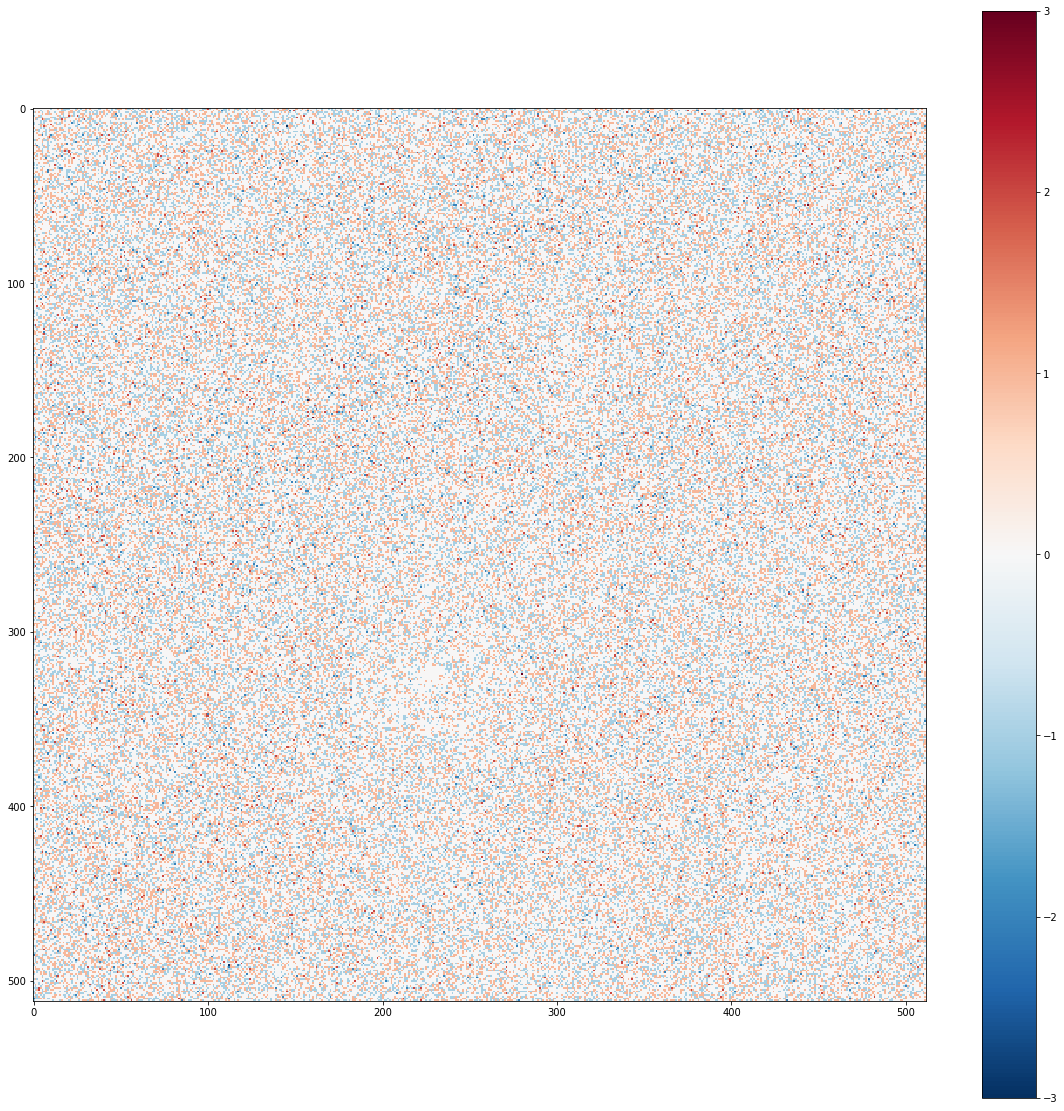

In [12]:
file = '4468.cr2'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = False
conf.embed.NS.a = 0.5 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal < 0] = 0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 4959.pef

4959.pef
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 153.8041512966156


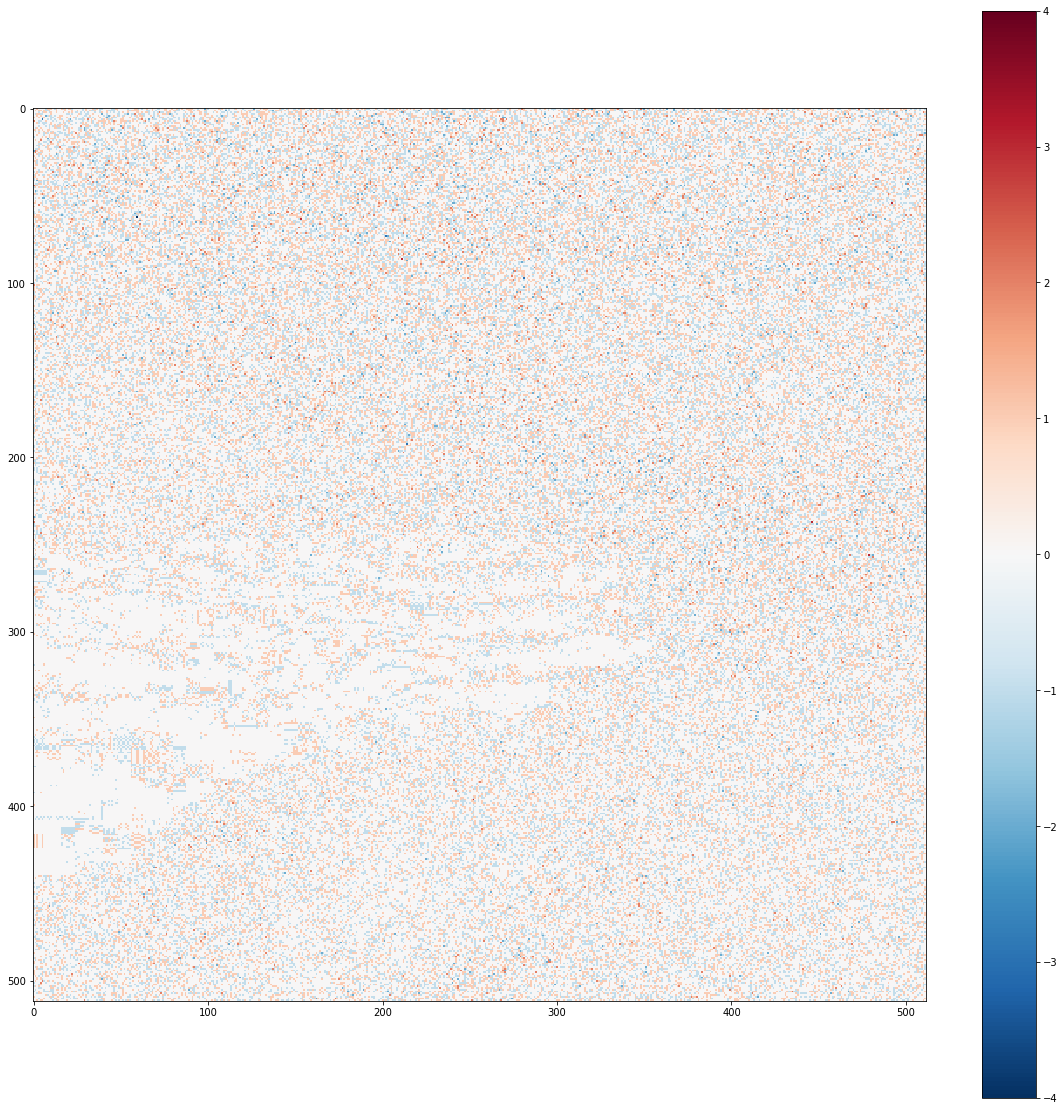

In [13]:
file = '4959.pef'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = False
conf.embed.NS.a = 0.3 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono4.DNG

Mono4.DNG
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 113.05137419700623


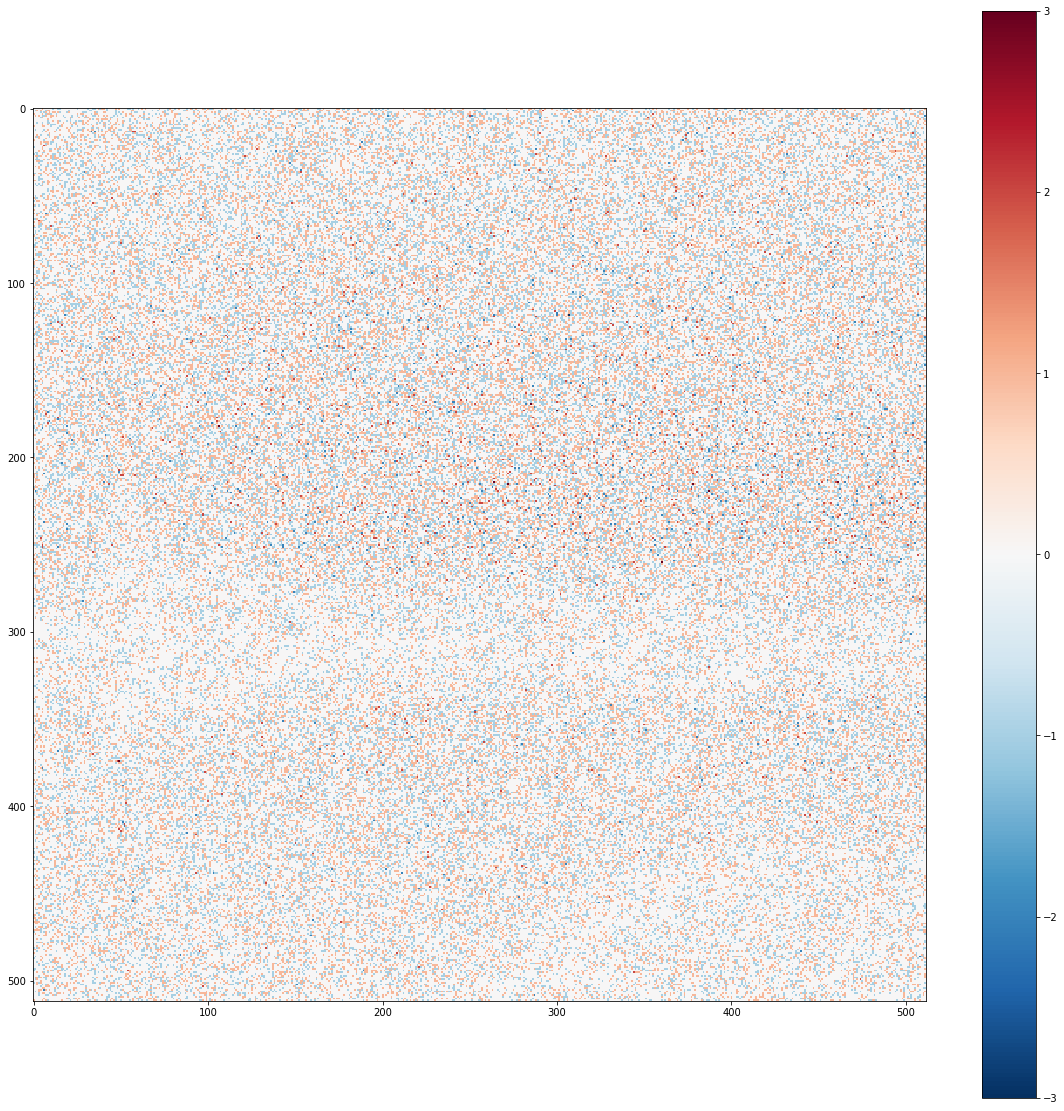

In [14]:
file = 'Mono4.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.5 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 
im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono5.DNG

Mono5.DNG
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 117.34699201583862


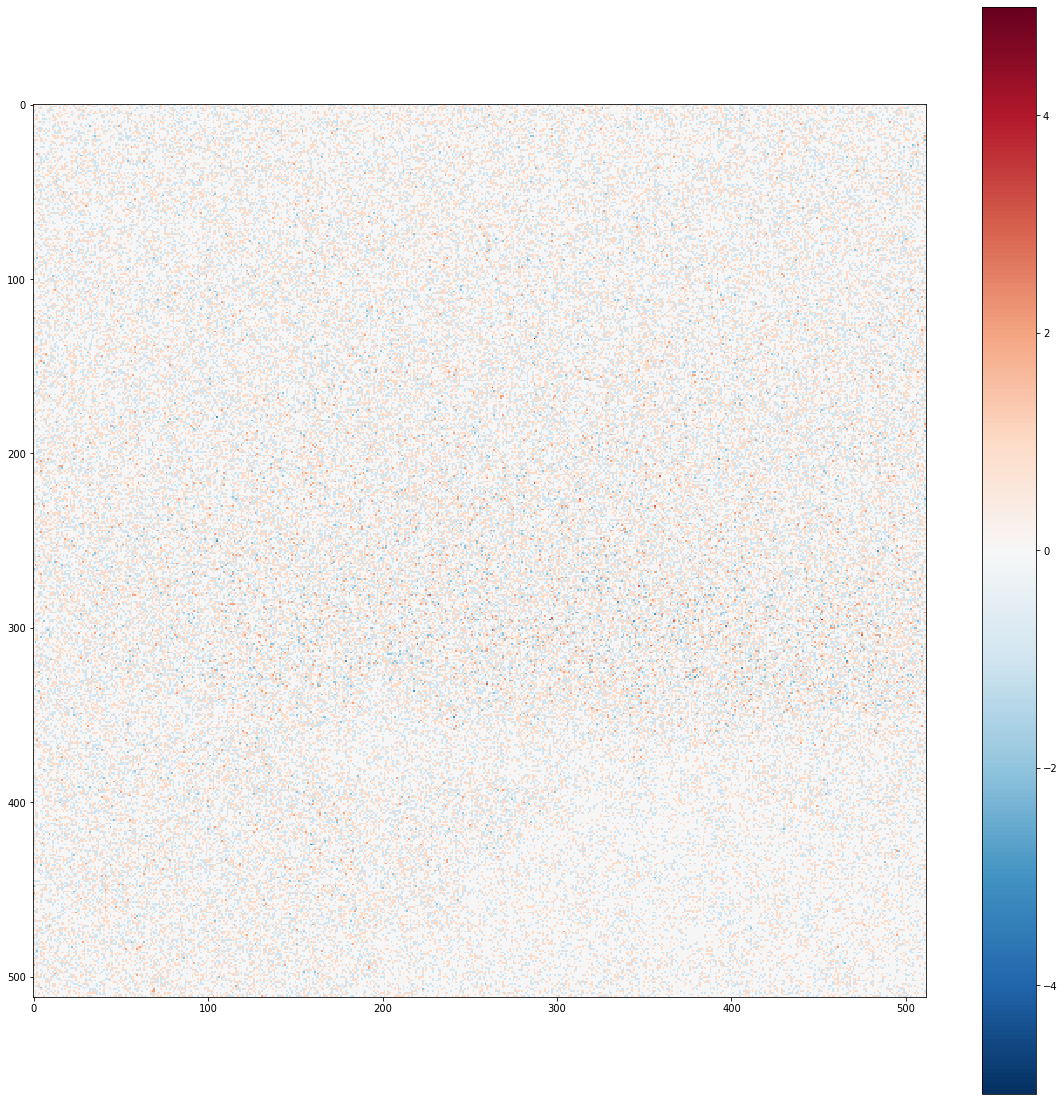

In [15]:
file = 'Mono5.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.5 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono1.DNG

Mono1.DNG
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 112.38003444671631


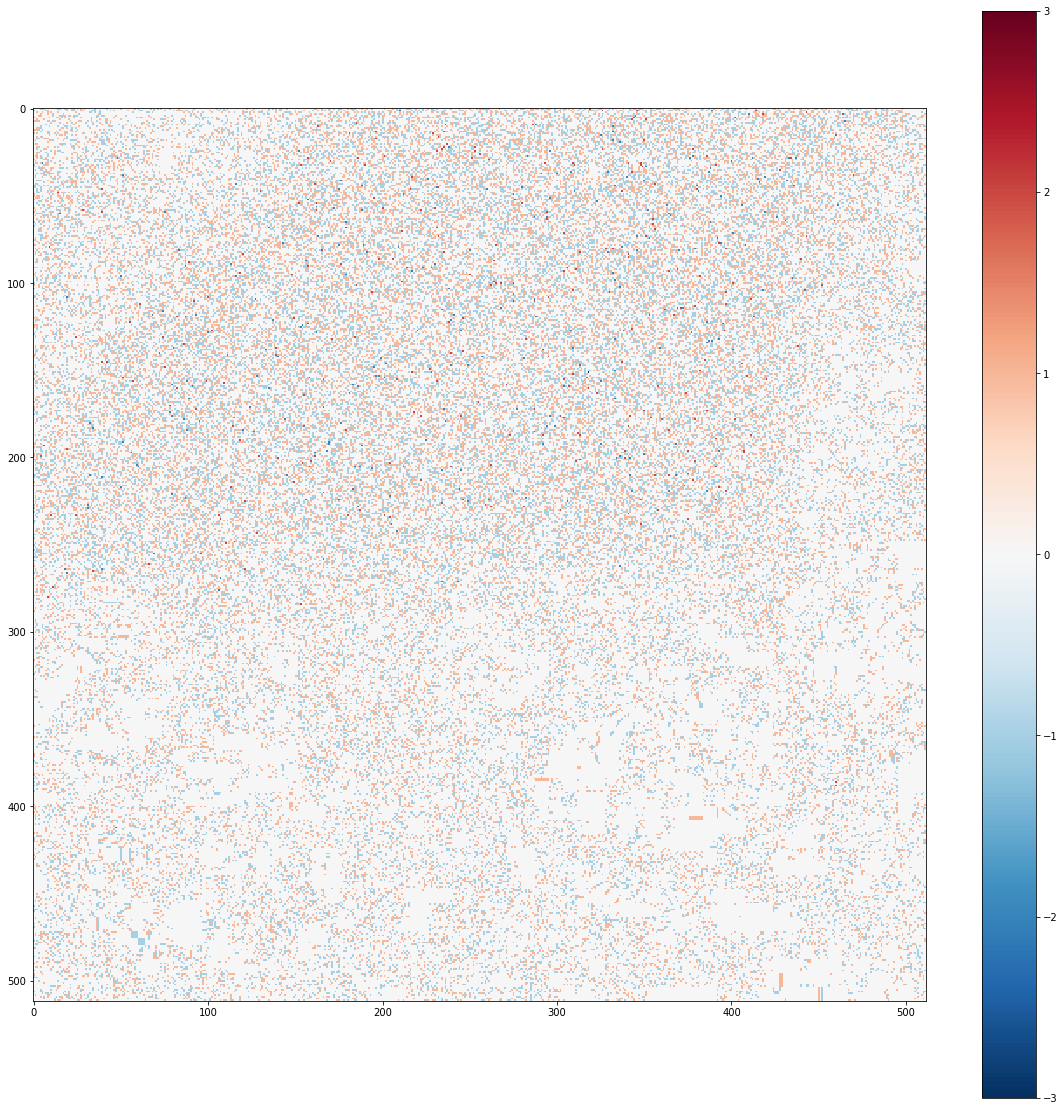

In [16]:
file = 'Mono1.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 3280.cr2

3280.cr2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 144.3913013935089


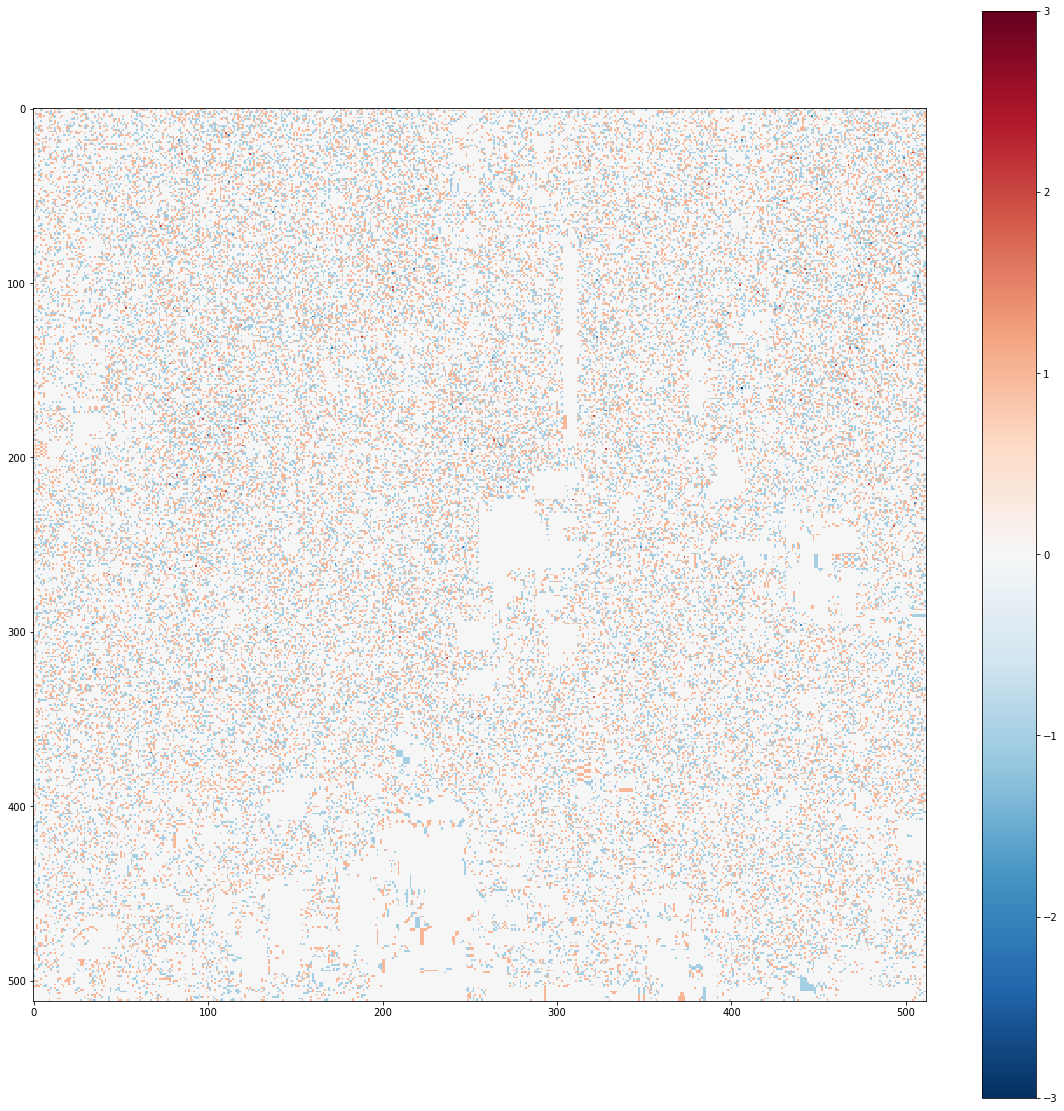

In [17]:
file = '3280.cr2'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = False
conf.embed.NS.a = 0.1 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg')  

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 6934.nef

6934.nef
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 90.67702412605286


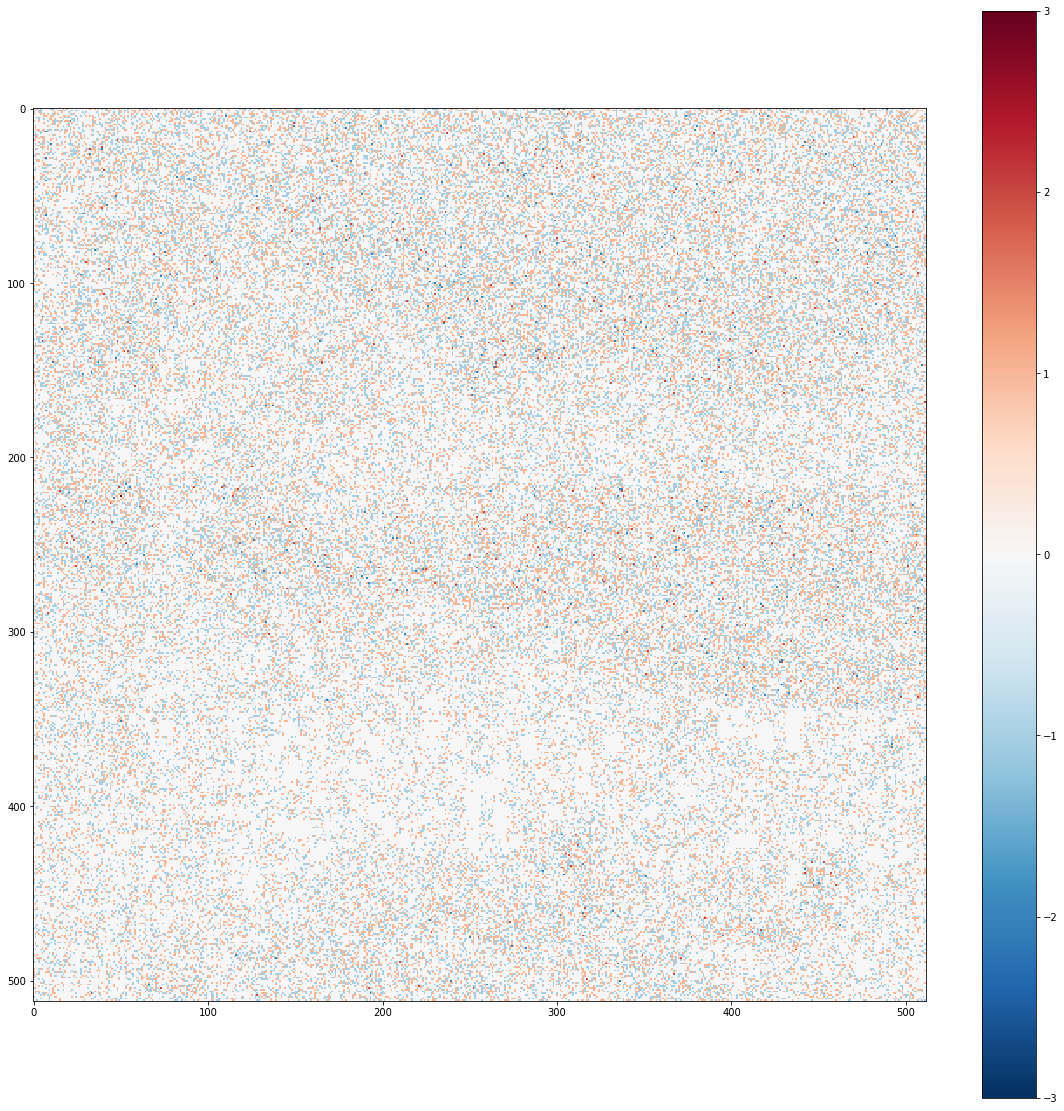

In [18]:
file = '6934.nef'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = False
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 4750.cr2

4750.cr2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 128.90040063858032


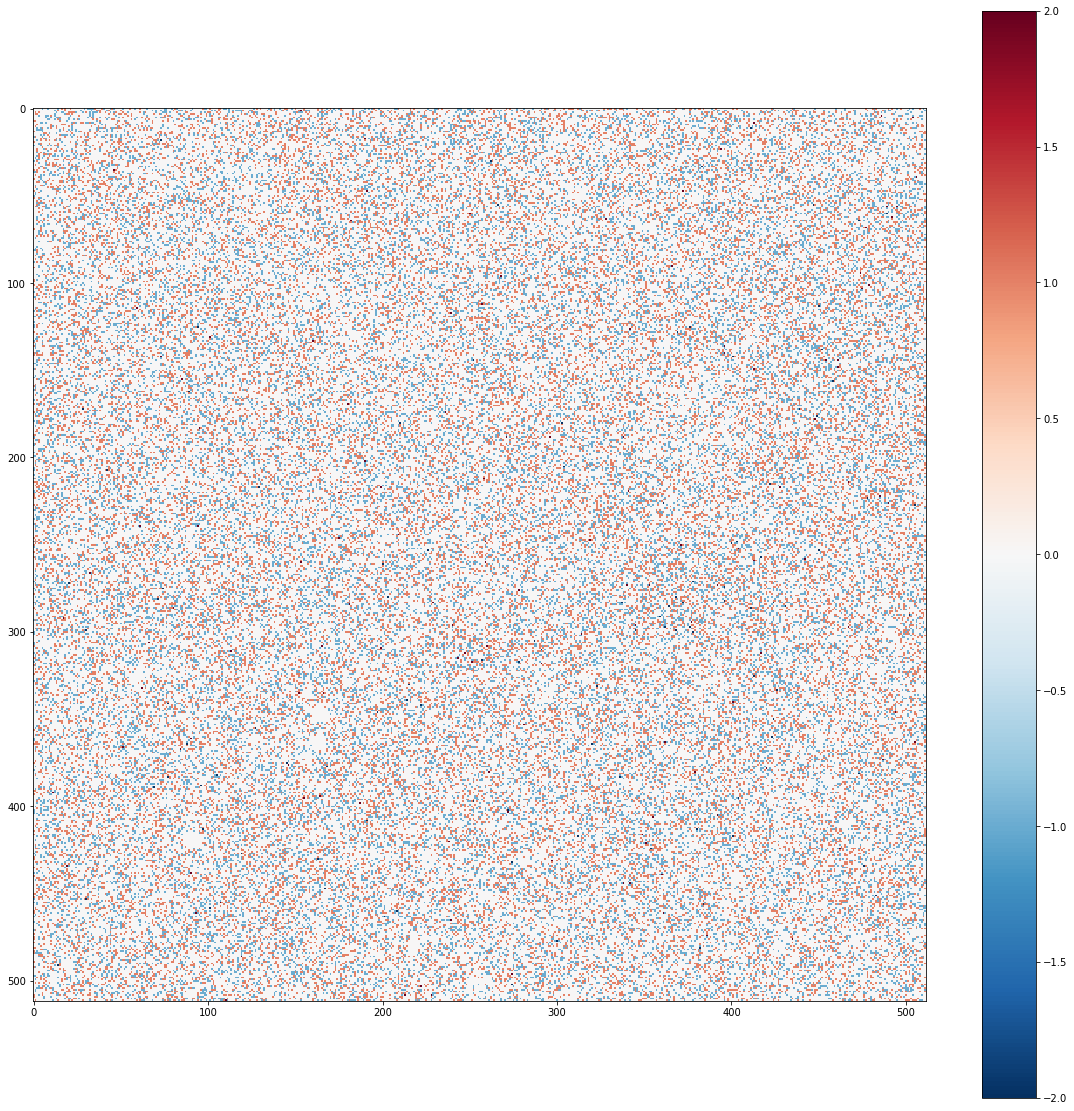

In [19]:
file = '4750.cr2'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = False
conf.embed.NS.a = 0.1 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg')  

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono3.DNG

Mono3.DNG
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 112.69849061965942


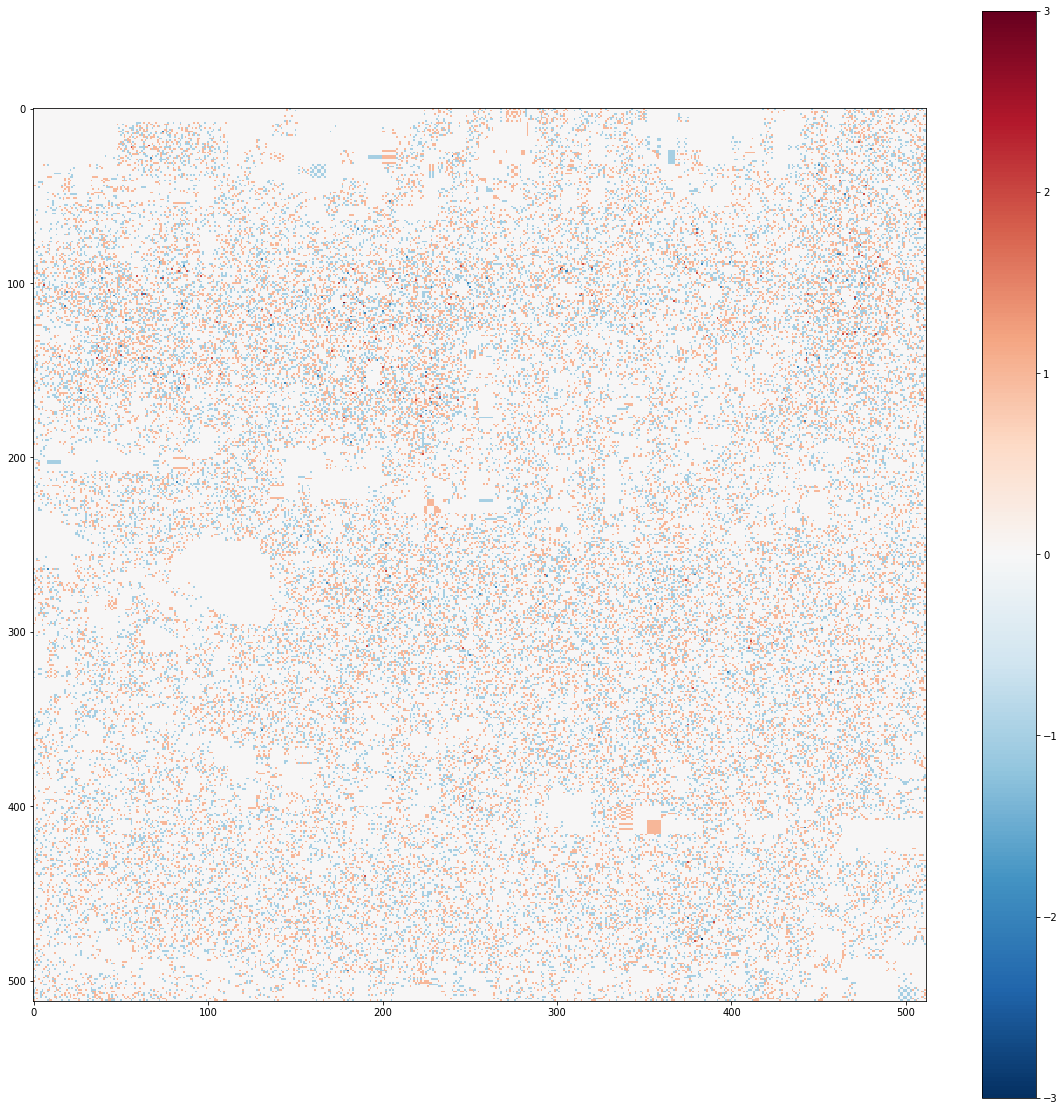

In [20]:
file = 'Mono3.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.1 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono2.DNG

Mono2.DNG
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Temps : 106.58867692947388


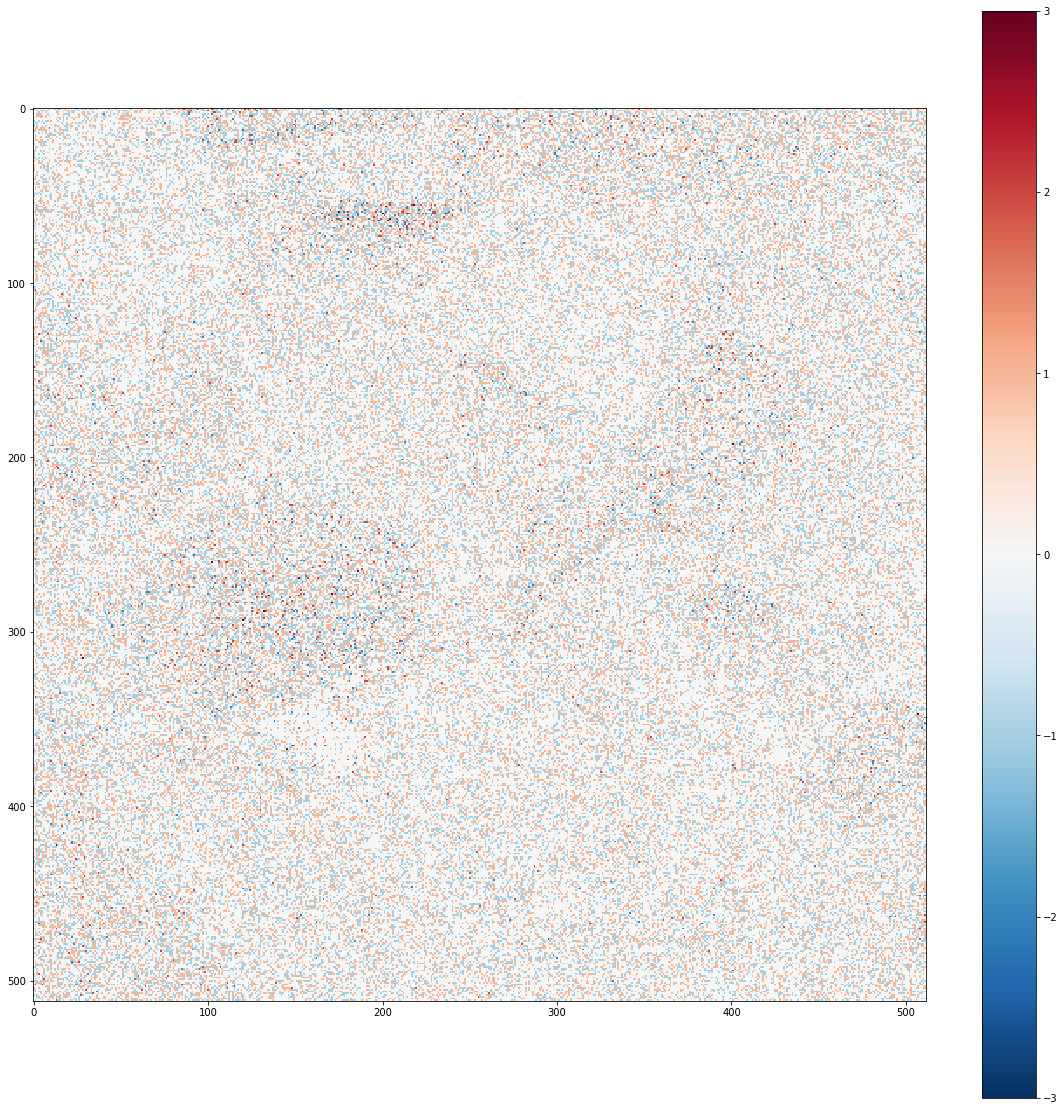

In [21]:
file = 'Mono2.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.3 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')
    
if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_cover = np.copy(raw_im.raw_image_visible)

h, w = im_cover.shape

debut = int((w-h)/2) # RAW ==> h < w
fin = int((w+h)/2)

im_pseudo_cover = np.zeros((h, h))
var_pseudo_cover_signal = im_cover[:,debut:fin]*a + b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

generate(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

In [22]:
print("Temps total :", time() - u)

Temps total : 1348.2625751495361
